In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs

In [2]:
import matplotlib
matplotlib.style.use('ggplot')

## Narrow Gaussian Experiment
\begin{align}
    \mu_0(x)=\mathcal{N}(x; 0, \textsf{Id})\qquad\qquad \pi(x)=\mathcal{N}(x; 1, \sigma^2\textsf{Id})
\end{align}
and
\begin{align}
    s(x) = \log \frac{\pi}{\mu_0}(x) = -((x-1)^2/\sigma^2-x^2)/2
\end{align}
with $\sigma^2 = 0.1^2$.

### WF-SMC

In [3]:
class ToyBridge(ssp.TemperingBridge):
    def logtarget(self, theta):
        return -0.5 * np.sum((theta-1)**2, axis=1)/(0.1**2)

In [4]:
d = 2
base_dist = dists.MvNormal(scale=1., cov=np.eye(d))
toy_bridge = ToyBridge(base_dist=base_dist)

In [5]:
fk_tpr = ssp.AdaptiveTempering(model=toy_bridge)
alg = particles.SMC(fk=fk_tpr, N=1000, ESSrmin=1., verbose=True)
alg.run()

t=0, ESS=5000.00, tempering exponent=0.0112
t=1, Metropolis acc. rate (over 9 steps): 0.356, ESS=5000.00, tempering exponent=0.044
t=2, Metropolis acc. rate (over 9 steps): 0.354, ESS=5000.00, tempering exponent=0.15
t=3, Metropolis acc. rate (over 9 steps): 0.351, ESS=5000.00, tempering exponent=0.5
t=4, Metropolis acc. rate (over 9 steps): 0.354, ESS=7392.32, tempering exponent=1


In [6]:
alg.cpu_time

0.4440947499999979

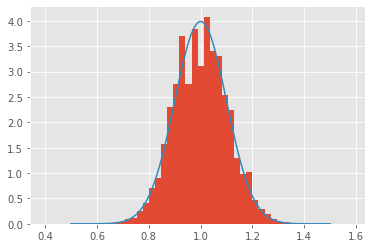

In [7]:
plt.hist(alg.X.theta[:, 0], density = True, weights = alg.W, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

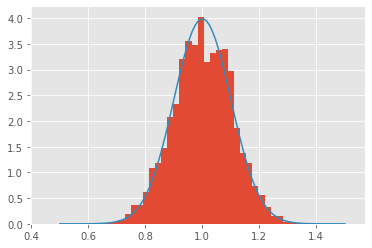

In [8]:
plt.hist(alg.X.theta[:, 1], density = True, weights = alg.W, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

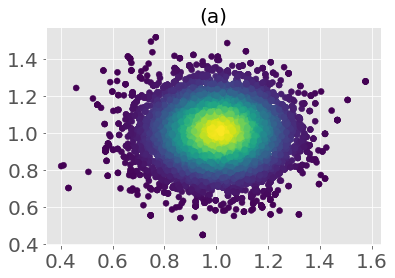

In [12]:
plt.scatter(alg.X.theta[:, 0], alg.X.theta[:, 1], c = alg.W)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.title("(a)", fontsize=20)
# plt.savefig('smc.pdf', bbox_inches="tight")

In [10]:
# ESS
1/np.sum(alg.W**2)/10000

0.7392318400114747

### CR-AIS

In [13]:
delta = 1/32
N = 10000
maxiter = 10000

In [14]:
def proposal(v, W):
    arr = ssp.view_2d_array(v)
    N, d = arr.shape
    m, cov = rs.wmean_and_cov(W, arr)
    scale = 2.38 / np.sqrt(d)
    L = scale * linalg.cholesky(cov, lower=True)
    arr_prop = arr + stats.norm.rvs(size=arr.shape) @ L.T
    return arr_prop
def RWM(v, l, W):
    prop = proposal(v, W)
    log_acceptance = -0.5*np.sum(prop**2 - v**2, axis = 1)
    log_acceptance = log_acceptance - 0.5*l*(np.sum((prop-1)**2/0.1**2 - prop**2, axis = 1) - np.sum((v-1)**2/0.1**2 - v**2, axis = 1))
    accepted = np.log(np.random.uniform(size = v.shape[0])) <= log_acceptance
    output = ssp.view_2d_array(v)
    output[accepted, :] = prop[accepted, :]
    return output

In [15]:
start_time = time.time()
n = 0
l = 0
while ((n < maxiter) & (l < 1)):
    if (n == 0):
        x = np.random.normal(size = (N, d))
        logW = -np.sum(x**2, axis = 1)/2
        beta = 1
    else:
        # MCMC move
        x = RWM(x, l, W)
    # adapt
    logW_adapt = -0.5*(np.sum((x-1)**2, axis = 1)/0.1**2 + np.sum(x**2, axis = 1))
    new_beta = beta*np.exp(-delta/((beta**2*np.var(logW_adapt))))
    l = 1 - new_beta
    if (l >= 1): l = 1
    # reweight
    logW = logW - (beta - new_beta)*0.5*(np.sum((x-1)**2, axis = 1)/0.1**2 - np.sum(x**2, axis = 1))
    W = rs.exp_and_normalise(logW)
    beta = new_beta
    n = n+1
logW = logW - 0.5*(np.sum((x-1)**2, axis = 1)/0.1**2)
print(time.time()-start_time, n-1)
# print(n-1)

36.57205390930176 6269


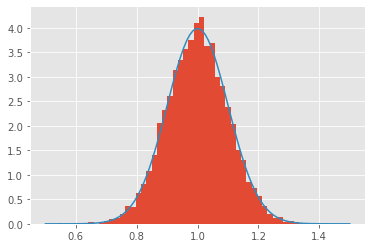

In [16]:
plt.hist(x[:,0], density = True, weights = W, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

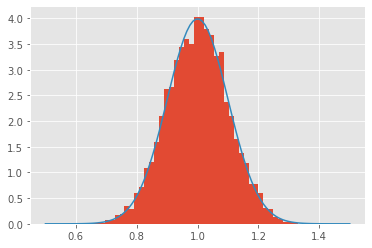

In [17]:
plt.hist(x[:,1], density = True, weights = W, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

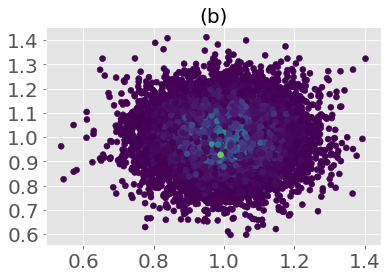

In [20]:
plt.scatter(x[:, 0], x[:, 1], c = W)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.title("(b)", fontsize=20)
# plt.savefig('cr_ais.pdf', bbox_inches="tight")

In [19]:
# ESS
W = rs.exp_and_normalise(logW)
1/np.sum(W**2)/N

0.3797821567865644

### Constant step size MD with SMC

In [21]:
gamma = 0.05
maxiter = 1000
N = 10000
sigma = 0.1

In [22]:
1-(1-gamma)**(maxiter)

1.0

In [23]:
start_time = time.time()
n = 0
l = 0
while ((n < maxiter) & (l < 1)):
    if (n == 0):
        x_smc = np.random.normal(size = (N, d))
        W_smc = np.ones(N)/N
    else:
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W)
            x_smc = x_smc[ancestors, :]
        # MCMC move
        x_smc = RWM(x_smc, 1-(1-gamma)**n, W_smc)
        # reweight  
        logW = -(0.5*(np.sum((x_smc-1)**2, axis = 1)/0.1**2 - np.sum(x_smc**2, axis = 1)))*gamma*(1-gamma)**(n-1)
        W_smc = rs.exp_and_normalise(logW)
        l = 1-(1-gamma)**n
    n = n+1
print(time.time()-start_time, n-1)

4.32128119468689 730


In [24]:
1-(1-gamma)**(n-1)

1.0

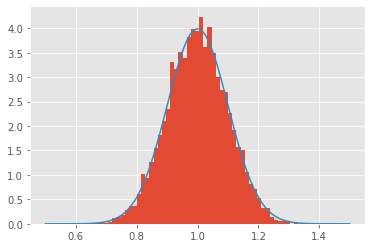

In [25]:
plt.hist(x_smc[:,0], density = True, weights = W_smc, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

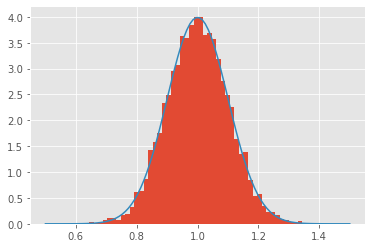

In [26]:
plt.hist(x_smc[:,1], density = True, weights = W_smc, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

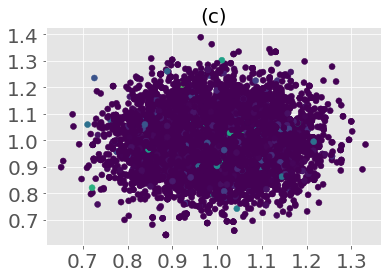

In [37]:
plt.scatter(x_smc[:, 0], x_smc[:, 1], c = W)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.title("(c)", fontsize=20)
# plt.savefig('smc_constant_gamma.pdf', bbox_inches="tight")

In [28]:
# ESS
1/np.sum(W_smc**2)/N

0.9999999999999998

### Constant step size MD with AIS

In [29]:
gamma = 0.05
maxiter = 1000
N = 10000
sigma = 0.1

In [30]:
1-(1-gamma)**(maxiter)

1.0

In [31]:
start_time = time.time()
n = 0
l = 0
while ((n < maxiter) & (l < 1)):
    if (n == 0):
        x = np.random.normal(size = (N, d))
        logW = np.zeros(N)
    else:
        # MCMC move
        x = RWM(x, 1-(1-gamma)**n, W)
        # reweight  
        logW = logW-(0.5*(np.sum((x-1)**2, axis = 1)/0.1**2 - np.sum(x**2, axis = 1)))*gamma*(1-gamma)**(n-1)
        W = rs.exp_and_normalise(logW)
    l = 1-(1-gamma)**n
    n = n+1
print(time.time()-start_time, n-1)

3.7124757766723633 730


In [32]:
1-(1-gamma)**(n-1)

1.0

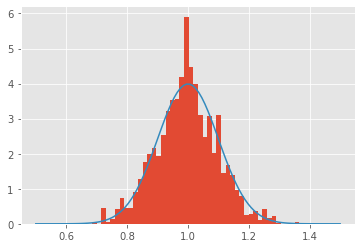

In [33]:
plt.hist(x[:,0], density = True, weights = W, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

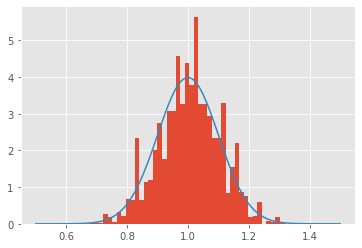

In [34]:
plt.hist(x[:,1], density = True, weights = W, bins = 50)
plt.plot(np.linspace(0.5, 1.5, 100), norm.pdf(np.linspace(0.5, 1.5, 100), loc = 1, scale = 0.1))

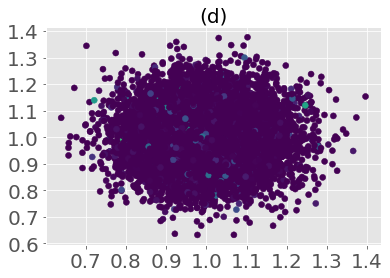

In [35]:
plt.scatter(x[:, 0], x[:, 1], c = W)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.title("(d)", fontsize=20)
# plt.savefig('md_constant_ais.pdf', bbox_inches="tight")

In [36]:
# ESS
W = rs.exp_and_normalise(logW)
1/np.sum(W**2)/N

0.04277147265751394

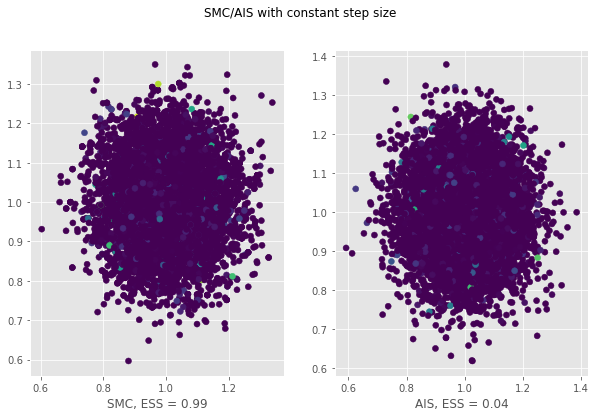

In [55]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.suptitle('SMC/AIS with constant step size')
plt.scatter(x_smc[:, 0], x_smc[:, 1], c = W)
plt.xlabel('SMC, ESS = 0.99')
plt.subplot(1, 2, 2)
plt.scatter(x[:, 0], x[:, 1], c = W)
plt.xlabel('AIS, ESS = 0.04')
plt.savefig('git.pdf', bbox_inches="tight")